<a href="https://colab.research.google.com/github/TeddyAbraham/Zee_Business_Case/blob/main/Zee_Business_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ==  ZeeRecommenderSystem ==
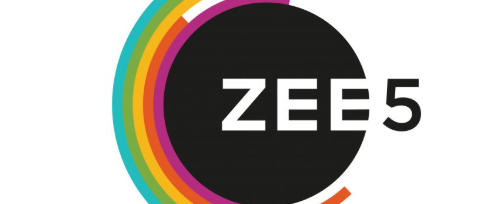

Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

Data Dictionary:

RATINGS FILE DESCRIPTION
=========================================================================

All ratings are contained in the file "ratings.dat" and are in the following format:

UserID::MovieID::Rating::Timestamp

UserIDs range between 1 and 6040

MovieIDs range between 1 and 3952

Ratings are made on a 5-star scale (whole-star ratings only)

Timestamp is represented in seconds

Each user has at least 20 ratings

USERS FILE DESCRIPTION
=========================================================================

User information is in the file "users.dat" and is in the following format:<br>

UserID::Gender::Age::Occupation::Zip-code <br>

All demographic information is provided voluntarily by the users and is not checked for accuracy. Only users who have provided some demographic information are included in this data set. <br>

Gender is denoted by a "M" for male and "F" for female <br>

Age is chosen from the following ranges: <br>

1: "Under 18" <br>
18: "18-24" <br>
25: "25-34" <br>
35: "35-44" <br>
45: "45-49" <br>
50: "50-55" <br>
56: "56+" <br>

Occupation is chosen from the following choices: <br>
0: "other" or not specified <br>
1: "academic/educator" <br>
2: "artist" <br>
3: "clerical/admin" <br>
4: "college/grad student" <br>
5: "customer service" <br>
6: "doctor/health care" <br>
7: "executive/managerial" <br>
8: "farmer" <br>
9: "homemaker" <br>
10: "K-12 student" <br>
11: "lawyer" <br>
12: "programmer" <br>
13: "retired" <br>
14: "sales/marketing" <br>
15: "scientist" <br>
16: "self-employed" <br>
17: "technician/engineer" <br>
18: "tradesman/craftsman" <br>
19: "unemployed" <br>
20: "writer" <br>

MOVIES FILE DESCRIPTION
=========================================================================

Movie information is in the file "movies.dat" and is in the following format:
MovieID::Title::Genres
Titles are identical to titles provided by the IMDB (including year of release)
Genres are pipe-separated and are selected from the following genres: <br>
Action | Adventure | Animation | Children's | Comedy | Crime | Documentary |Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western

Concepts covered
========================================================================

- Recommender Engine
- Collaborative Filtering (Item-based & User-based Approach)

- Pearson Correlation

- Nearest Neighbors using Cosine Similarity

- Matrix Factorization



In [ ]:
import pandas as pd
import numpy as np
import math as math
import keras
import seaborn as sns
sns.set(style='whitegrid')
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 6)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
movies = pd.read_fwf('/content/drive/MyDrive/Scaler/Business Case study/csvs/Zee/zee-movies.dat',encoding = 'ISO-8859-1')
ratings = pd.read_fwf('/content/drive/MyDrive/Scaler/Business Case study/csvs/Zee/zee-ratings.dat',encoding = 'ISO-8859-1')
users = pd.read_fwf('/content/drive/MyDrive/Scaler/Business Case study/csvs/Zee/zee-users.dat',encoding = 'ISO-8859-1')

In [ ]:
print(movies.shape)
print(ratings.shape)
print(users.shape)

(3883, 3)
(1000209, 1)
(6040, 1)


In [ ]:
movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [ ]:
movies.drop(columns = ['Unnamed: 1', 'Unnamed: 2'], inplace=True)
delimiter = '::'
movies = movies['Movie ID::Title::Genres'].str.split(delimiter, expand=True)
movies.columns = ['Movie ID', 'Title', 'Genres']
movies.head(2)

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


In [ ]:
print(ratings.shape)
ratings.head()

(1000209, 1)


,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [ ]:
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimiter, expand=True)
ratings.columns = ['User ID', 'Movie ID', 'Rating', 'Timestamp']
ratings.head()

,User ID,Movie ID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
print(users.shape)
users.head()

(6040, 1)


,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [ ]:
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimiter, expand=True)
users.columns = ['User ID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users.head()

,User ID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Mergeing All tables


In [ ]:
movies_ratings = pd.merge(movies, ratings, on='Movie ID')
df = pd.merge(movies_ratings, users, on='User ID')

In [ ]:
df.head()

,Movie ID,Title,Genres,User ID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,F,50,9,55117
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,M,25,12,11413
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,M,25,17,61614
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,F,35,1,95370


In [ ]:
df.shape

(1000209, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Movie ID    1000209 non-null  object
 1   Title       1000209 non-null  object
 2   Genres      996144 non-null   object
 3   User ID     1000209 non-null  object
 4   Rating      1000209 non-null  object
 5   Timestamp   1000209 non-null  object
 6   Gender      1000209 non-null  object
 7   Age         1000209 non-null  object
 8   Occupation  1000209 non-null  object
 9   Zip-code    1000209 non-null  object
dtypes: object(10)
memory usage: 76.3+ MB


Changing Dtype formats & Feture Engeneering:

In [ ]:
df['Rating'] = df['Rating'].astype(int)
df['Age'] = df['Age'].astype(int)

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

In [ ]:
# First, split on ' (' to separate title and year
df['Release Year'] = df['Title'].str.split('(').str[-1].str.replace(')', '')

In [ ]:
df.replace({'Age':{1: "Under 18",
                   18: "18-24",
                   25: "25-34",
                   35: "35-44",
                   45: "45-49",
                   50: "50-55",
                   56: "56+"}},inplace=True)

In [ ]:
df.replace({'Occupation':{'0': "other" or not specified,
                          '1': "academic/educator",
                          '2': "artist",
                          '3': "clerical/admin",
                          '4': "college/grad student",
                          '5': "customer service",
                          '6': "doctor/health care",
                          '7': "executive/managerial",
                          '8': "farmer",
                          '9': "homemaker",
                          '10': "K-12 student",
                          '11': "lawyer",
                          '12': "programmer",
                          '13': "retired",
                          '14': "sales/marketing",
                          '15': "scientist",
                          '16': "self-employed",
                          '17': "technician/engineer",
                          '18': "tradesman/craftsman",
                          '19': "unemployed",
                          '20': "writer"

}},inplace=True)

In [ ]:
df.head()

,Movie ID,Title,Genres,User ID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Release Year
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,2001-01-06 23:37:48,F,Under 18,K-12 student,48067,1995
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,2000-12-31 04:30:08,F,50-55,homemaker,55117,1995
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,2000-12-31 03:31:36,M,25-34,programmer,11413,1995
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,2000-12-31 01:25:52,M,25-34,technician/engineer,61614,1995
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,2000-12-31 01:34:34,F,35-44,academic/educator,95370,1995


In [ ]:
df['Release Year'].unique()

array(['1995', '1994', '1996',
       "Don't Be a Menace to South Central While Drinking Your Juice in the",
       '1976', '1993', '1992', '1988', '1967', '1964:', '1977',
       'Die Macht der B', '1965', '1982', '1962', '1990', '1991', '1989',
       '1937', '1940', '1969', '1981', '1973', '1970', '1960', '1955',
       '1956', '1959', '1968', '1980', '1975', '1995:', '1948', '1943',
       'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bo',
       '1950', '1987', '1997', "En compagnie d'Antonin Arta", '1974',
       '1958', '1972', '1998', '1952', '1951', '1957', '1961', '1954',
       '1934', '1944', '1963', '1942', '1941', '1964', '1953', '1939',
       '1947', '1946', '1945', '1938', '1935', '1936', '1926', '1949',
       '1932', '1930', '1971', '1979', '1986', '1966', '1978', '1985',
       '1983', '1984', '1933', '1931', '1922', '19', '1927', '1929',
       '195', '1928', '1999',
       "Travolti da un insolito destino nell'azzurro mare d'A",
       'Los Aman

In [ ]:
df[df['Release Year']== '19']

,Movie ID,Title,Genres,User ID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Release Year
396114,1362,"Garden of Finzi-Contini, The (Giardino dei Fin...",None,303,3,2000-12-11 03:18:35,M,25-34,executive/managerial,20006,19
396115,1362,"Garden of Finzi-Contini, The (Giardino dei Fin...",None,339,4,2000-12-09 06:13:10,M,50-55,executive/managerial,80207,19
396116,1362,"Garden of Finzi-Contini, The (Giardino dei Fin...",None,393,4,2000-12-08 17:49:33,M,35-44,technician/engineer,55402,19
396117,1362,"Garden of Finzi-Contini, The (Giardino dei Fin...",None,451,3,2000-12-10 02:40:56,M,56+,retired,54720,19
396118,1362,"Garden of Finzi-Contini, The (Giardino dei Fin...",None,515,3,2000-12-07 15:38:30,M,25-34,academic/educator,55406,19
...,...,...,...,...,...,...,...,...,...,...,...
950721,3680,Decline of Western Civilization Part II: The M...,None,5880,4,2000-06-15 19:01:31,M,25-34,academic/educator,08904,19
991490,3887,Went to Coney Island on a Mission From God... ...,None,1448,3,2001-01-08 16:58:38,F,25-34,clerical/admin,17522,19
991491,3887,Went to Coney Island on a Mission From God... ...,None,1470,3,2000-11-21 19:51:31,M,18-24,college/grad student,94118,19
991492,3887,Went to Coney Island on a Mission From God... ...,None,1877,2,2000-12-21 20:41:11,F,45-49,writer,90069,19


In [ ]:
df['Release Year'].replace(["Don't Be a Menace to South Central While Drinking Your Juice in the", 'Die Macht der B', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bo', "Travolti da un insolito destino nell'azzurro mare d'A", 'Lovers of the Arctic Circle, The', "Ceux qui m'aiment prendront", '', '1', '1964:', '1995:', '1981:', '1989:', '195', "En compagnie d'Antonin Arta", 'Los Amantes del Círculo Polar'],
 ['1996', '1993', '1964', '1974', '1998', '1998', '1970','1971', '1964', '1995', '1981', '1989', '1954', '1993', '1998'], inplace = True)

In [ ]:
df['Occupation'].unique()

array(['K-12 student', 'homemaker', 'programmer', 'technician/engineer',
       'academic/educator', 'clerical/admin', 'self-employed', 'other',
       'executive/managerial', 'college/grad student', 'writer',
       'retired', 'scientist', 'artist', 'customer service',
       'sales/marketing', 'doctor/health care', 'unemployed', 'lawyer',
       'farmer', 'tradesman/craftsman'], dtype=object)

Multiple Titles have Release Year == 19, so as of now leaving it as it is


In [ ]:
df['Release Year'] = df['Release Year'].astype(int)
df['Release Year'] =  pd.to_datetime(df['Release Year'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Movie ID      1000209 non-null  object        
 1   Title         1000209 non-null  object        
 2   Genres        996144 non-null   object        
 3   User ID       1000209 non-null  object        
 4   Rating        1000209 non-null  int64         
 5   Timestamp     1000209 non-null  datetime64[ns]
 6   Gender        1000209 non-null  object        
 7   Age           1000209 non-null  object        
 8   Occupation    1000209 non-null  object        
 9   Zip-code      1000209 non-null  object        
 10  Release Year  1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 83.9+ MB


In [ ]:
df.head()

,Movie ID,Title,Genres,User ID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Release Year
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,2001-01-06 23:37:48,F,Under 18,K-12 student,48067,1970-01-01 00:00:00.000001995
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,2000-12-31 04:30:08,F,50-55,homemaker,55117,1970-01-01 00:00:00.000001995
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,2000-12-31 03:31:36,M,25-34,programmer,11413,1970-01-01 00:00:00.000001995
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,2000-12-31 01:25:52,M,25-34,technician/engineer,61614,1970-01-01 00:00:00.000001995
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,2000-12-31 01:34:34,F,35-44,academic/educator,95370,1970-01-01 00:00:00.000001995


## Explorative Data Analysis

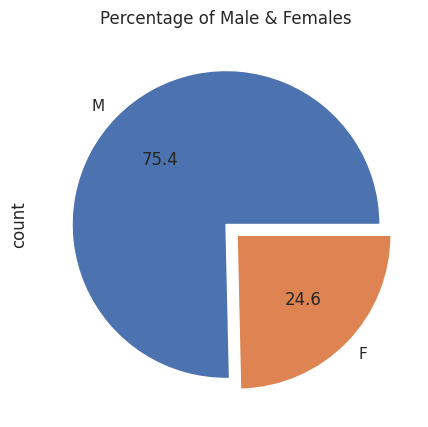

In [ ]:
df['Gender'].value_counts().plot(kind='pie',figsize=(5,5),autopct='%1.1f',explode=[0,0.1])
plt.title('Percentage of Male & Females')
plt.show()


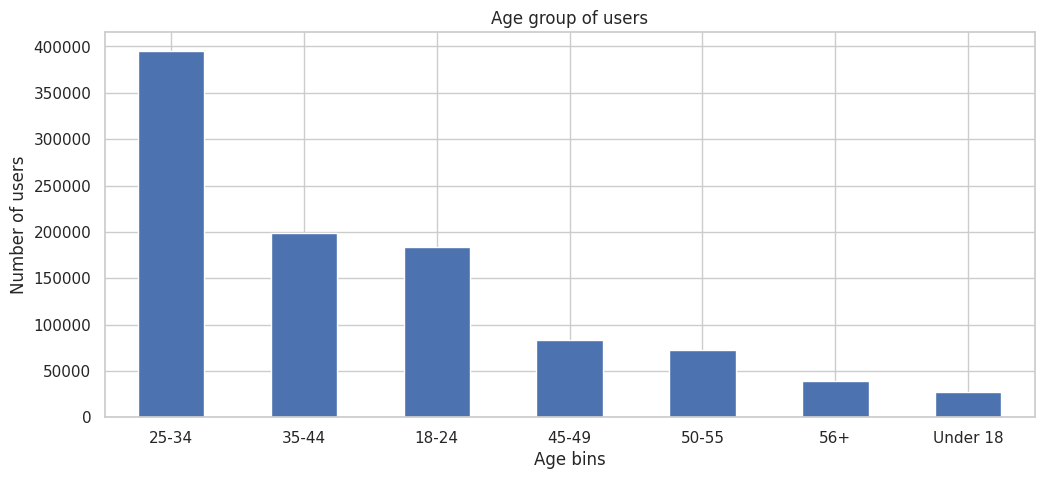

In [ ]:
df['Age'].value_counts().plot(kind='bar',figsize=(12,5))
plt.title('Age group of users')
plt.xlabel('Age bins')
plt.xticks(rotation = 360)
plt.ylabel('Number of users')
plt.show()

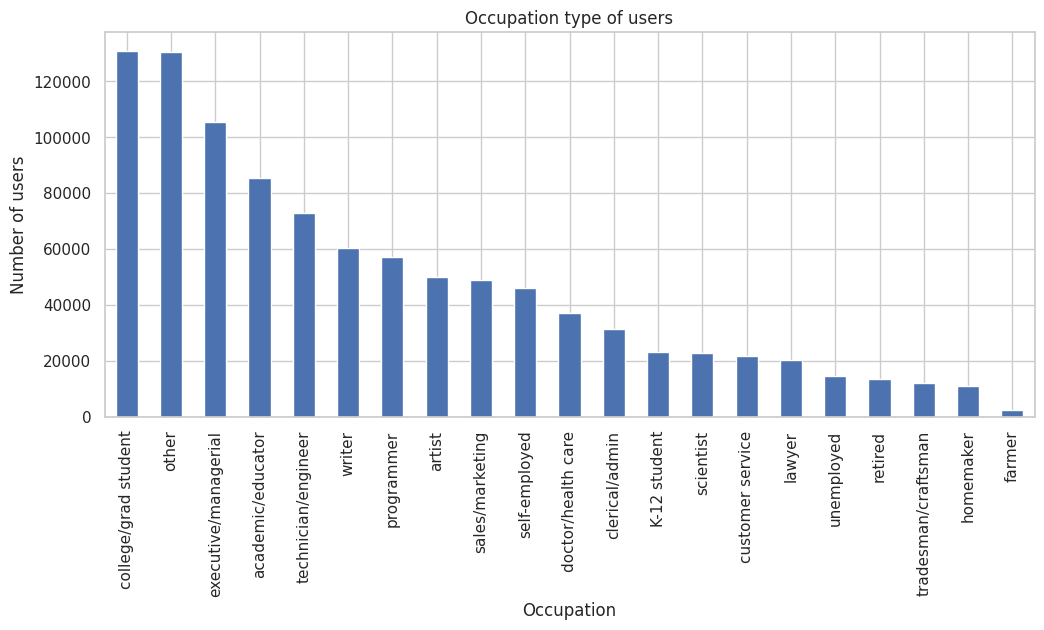

In [ ]:
df['Occupation'].value_counts().plot(kind='bar',figsize=(12,5))
plt.title('Occupation type of users')
plt.xlabel('Occupation')
# plt.xticks(rotation = 15)
plt.ylabel('Number of users')
plt.show()


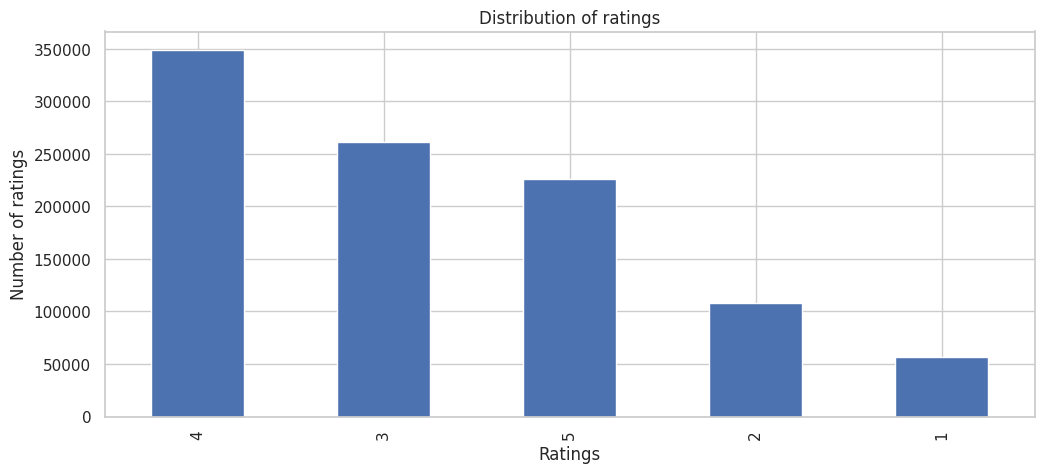

In [ ]:
df['Rating'].value_counts().plot(kind='bar',figsize=(12,5))
plt.title("Distribution of ratings")
plt.xlabel('Ratings')
plt.ylabel('Number of ratings')
plt.show()

In [ ]:
def missing_values(df):
    total_null = df.isnull().sum().sort_values(ascending  = False)
    percent_null = ((df.isnull().sum()/df.shape[0])*100).sort_values(ascending = False)
    print(f"Total records in our data =  {df.shape[0]} where missing values are as follows:")
    missing_data = pd.concat([total_null, percent_null.round(2)], axis = 1,keys=['Total Missing','In Percent'])
    return missing_data

In [ ]:
missing_values(df)

Total records in our data =  1000209 where missing values are as follows:


,Total Missing,In Percent
Genres,4065,0.41
Movie ID,0,0.00
Title,0,0.00
User ID,0,0.00
Rating,0,0.00
Timestamp,0,0.00
Gender,0,0.00
Age,0,0.00
Occupation,0,0.00
Zip-code,0,0.00


In [ ]:
duplicates = df[df.duplicated()]
print('The number of duplicates rows:', duplicates.shape[0])

The number of duplicates rows: 0


### Data Aggregation:

In [ ]:
# Grouping the data in terms of Average Rating and No. of Ratings given

df.groupby('Title')['Rating'].mean().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Average Rating'})

,Title,Average Rating
0,Lured (1947),5.0
1,Ulysses (Ulisse) (1954),5.0
2,"Baby, The (1973)",5.0
3,Follow the Bitch (1998),5.0
4,Schlafes Bruder (Brother of Sleep) (1995),5.0
...,...,...
3701,Terror in a Texas Town (1958),1.0
3702,White Boys (1999),1.0
3703,Mutters Courage (1995),1.0
3704,Shadows (Cienie) (1988),1.0


In [ ]:
df.groupby('Title')['Rating'].count().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Count'})

,Title,Count
0,American Beauty (1999),3428
1,Star Wars: Episode IV - A New Hope (1977),2991
2,Star Wars: Episode V - The Empire Strikes Back...,2990
3,Star Wars: Episode VI - Return of the Jedi (1983),2883
4,Jurassic Park (1993),2672
...,...,...
3701,One Little Indian (1973),1
3702,Nueba Yol (1995),1
3703,Number Seventeen (1932),1
3704,Windows (1980),1


In [ ]:
df_2 = pd.merge(df.groupby('Title')['Rating'].mean().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Average Rating'}),df.groupby('Title')['Rating'].count().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Count'}),on='Title')
df_2.head()

,Title,Average Rating,Count
0,Lured (1947),5.0,1
1,Ulysses (Ulisse) (1954),5.0,1
2,"Baby, The (1973)",5.0,1
3,Follow the Bitch (1998),5.0,1
4,Schlafes Bruder (Brother of Sleep) (1995),5.0,1


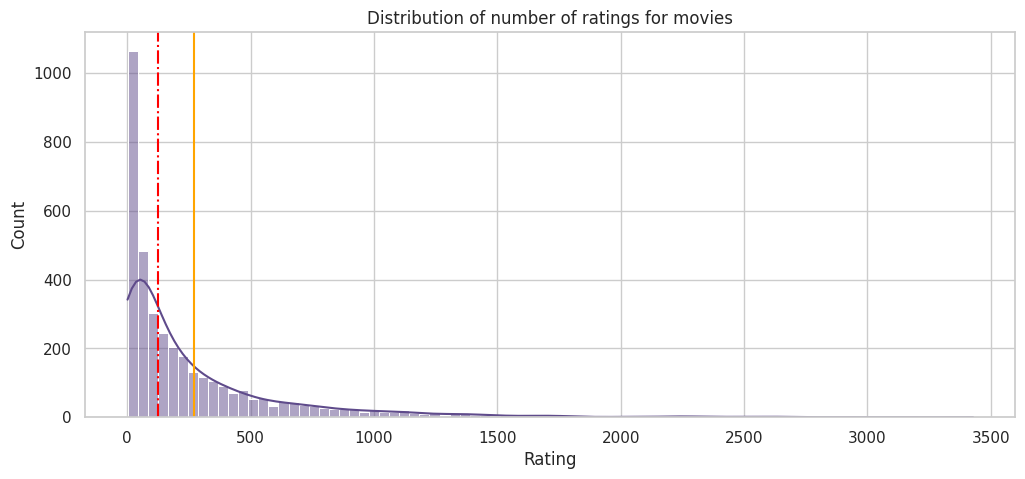

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
sns.histplot(df.groupby('Title')['Rating'].count(),kde=True,ax=ax,color='#5F4B8B')
ax.axvline(df.groupby('Title')['Rating'].count().mean(), color='orange', linestyle='-',linewidth=1.5)
ax.axvline(df.groupby('Title')['Rating'].count().median(), color='red', linestyle='-.',linewidth=1.5)
ax.set_title("Distribution of number of ratings for movies")
plt.show()

In [ ]:
df.groupby('Title')['Rating'].count().median(), df.groupby('Title')['Rating'].count().mean().round(2)

(123.5, np.float64(269.89))

On an average, every movie receives 270 ratings and the median count for ratings is 123. Hence we shall filter all movies which have received less than 123 ratings to find the top rated movies

### Top 5 Rating-wise movies:

In [ ]:
df_2[df_2['Count'] > 123].sort_values(by=['Average Rating'],ascending=False).head(5)

,Title,Average Rating,Count
14,Seven Samurai (The Magnificent Seven) (Shichin...,4.560510,628
15,"Shawshank Redemption, The (1994)",4.554558,2227
16,"Godfather, The (1972)",4.524966,2223
17,"Close Shave, A (1995)",4.520548,657
18,"Usual Suspects, The (1995)",4.517106,1783


## Building a Recommender System based on Pearson Correlation
#### Creating a pivot table of movie titles & user id and imputing the NaN values

In [ ]:
# pivot table

tab = pd.pivot_table(df,index='User ID',columns='Title',values='Rating',aggfunc='mean')
tab.head()

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
User ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0


In [ ]:
tab.shape

(6040, 3706)

We can clearly see that there are a lot of NaN values, we should fill it with 0. We have a sparse matrix

In [ ]:
tab.fillna(0, inplace = True)

## Item based approach
Here we shall take a movie name as input from the user and return 5 other movies which are similar to the user's choice. To calculate the similarity, I am using pearson correlation.

In [ ]:
movies.Title.head()

,Title
0,Toy Story (1995)
1,Jumanji (1995)
2,Grumpier Old Men (1995)
3,Waiting to Exhale (1995)
4,Father of the Bride Part II (1995)


In [ ]:
Toy Story (1995)mov = input("Enter a movie name : ")
mov_rating = tab[mov]

Enter a movie name : Toy Story (1995)


In [ ]:
similar_movies = tab.corrwith(mov_rating)
similar_movies.head(2)

,0
Title,
"$1,000,000 Duck (1971)",0.051744
'Night Mother (1986),0.042108


In [ ]:
#Pearson Correlation

similar_movies.sort_values(ascending=False).to_frame().rename(columns={0:"Correlation"}).head()

,Correlation
Title,
Toy Story (1995),1.000000
Toy Story 2 (1999),0.487370
Aladdin (1992),0.470753
"Lion King, The (1994)",0.411131
Groundhog Day (1993),0.407547


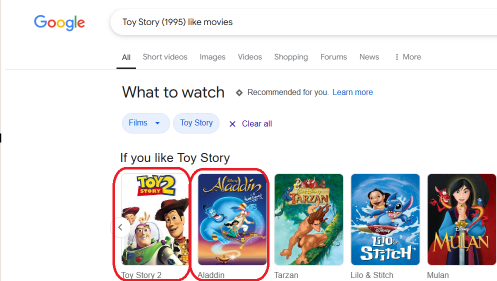

- As we can clearly see, out of the 4 movies that our simple Pearson Correlation based Recomm System recommended, we got two movies (highlighed) which are recommended by Google also.
- Which means, our simple system is pretty descent.

## User-based approach
Using the User-based approach to create a recommender system that uses Pearson Correlation

In [ ]:
tab_transpose = tab.T
tab_transpose

User ID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Night Mother (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"'burbs, The (1989)",0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And Justice for All (1979),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zed & Two Noughts, A (1985)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zero Effect (1998),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zero Kelvin (Kjærlighetens kjøtere) (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_id = input("Enter a user_id : ")
user_id_recomm = tab_transpose[user_id]

Enter a user_id : 5


In [ ]:
similar_movie_user_based = tab_transpose.corrwith(user_id_recomm)
similar_movie_user_based = pd.DataFrame(similar_movie_user_based, columns=["Correlation"])
similar_movie_user_based.dropna(inplace=True)
similar_movie_user_based.head()

,Correlation
User ID,
1,0.066521
10,0.050791
100,0.089274
1000,0.078778
1001,0.223679


Observation #
- As we can clearly see, movies interests similar to user with user id == 5 are the users(1,10, 100, 1000, 1001) and thus we can recommend these users similar movies that user_id == 5 is watching.
- User_id 100 have a pretty good correlation with 89%.

## Building a Recommender System based on Cosine Similarity and KNN

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
item_sim = cosine_similarity(tab.T) # row based and hence for getting moview (items) entries in rows, we are transposing
item_sim

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

### Item-Item Similarity:

In [ ]:
# Item-Item Similarity Matrix

item_sim_mat = pd.DataFrame(item_sim,index=tab.columns,columns = tab.columns)
item_sim_mat

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",1.000000,0.072357,0.037011,0.079291,0.060838,0.000000,0.058619,0.189965,0.172254,0.094785,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother (1986),0.072357,1.000000,0.115290,0.115545,0.159526,0.000000,0.076798,0.147437,0.095922,0.111413,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You (1997),0.037011,0.115290,1.000000,0.098756,0.066301,0.080250,0.127895,0.112654,0.125670,0.079115,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The (1989)",0.079291,0.115545,0.098756,1.000000,0.143620,0.000000,0.192191,0.246927,0.175885,0.170719,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All (1979),0.060838,0.159526,0.066301,0.143620,1.000000,0.000000,0.075093,0.194154,0.116379,0.205486,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zed & Two Noughts, A (1985)",0.045280,0.091150,0.022594,0.055704,0.086080,0.000000,0.012702,0.048761,0.018537,0.039344,...,0.047282,0.073996,0.070409,0.141537,0.0,1.000000,0.084020,0.124939,0.000000,0.137372
Zero Effect (1998),0.039395,0.074787,0.079261,0.161174,0.110867,0.000000,0.175771,0.146381,0.094669,0.133061,...,0.179315,0.169677,0.021362,0.206870,0.0,0.084020,1.000000,0.059228,0.016838,0.242043
Zero Kelvin (Kjærlighetens kjøtere) (1995),0.000000,0.000000,0.000000,0.000000,0.074317,0.000000,0.000000,0.036113,0.000000,0.036867,...,0.048440,0.046892,0.000000,0.000000,0.0,0.124939,0.059228,1.000000,0.000000,0.045644


In [ ]:
user_sim = cosine_similarity(tab)
user_sim

array([[1.        , 0.25528755, 0.12396703, ..., 0.15926709, 0.11935626,
        0.12205855],
       [0.25528755, 1.        , 0.25804672, ..., 0.16034613, 0.13250616,
        0.24625103],
       [0.12396703, 0.25804672, 1.        , ..., 0.20430203, 0.11352239,
        0.30610356],
       ...,
       [0.15926709, 0.16034613, 0.20430203, ..., 1.        , 0.18657496,
        0.18245166],
       [0.11935626, 0.13250616, 0.11352239, ..., 0.18657496, 1.        ,
        0.10797727],
       [0.12205855, 0.24625103, 0.30610356, ..., 0.18245166, 0.10797727,
        1.        ]])

##User-User Similarity:

In [ ]:
# User Similarity Matrix:

user_sim_mat = pd.DataFrame(user_sim,index=tab.index,columns = tab.index)
user_sim_mat

User ID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
User ID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.255288,0.123967,0.207800,0.139061,0.110320,0.121384,0.179143,0.103137,0.052816,...,0.079367,0.038048,0.032136,0.066641,0.070052,0.035731,0.170184,0.159267,0.119356,0.122059
10,0.255288,1.000000,0.258047,0.278753,0.154858,0.112222,0.141111,0.428224,0.188569,0.101856,...,0.153462,0.186086,0.083224,0.123288,0.117829,0.145650,0.300175,0.160346,0.132506,0.246251
100,0.123967,0.258047,1.000000,0.297539,0.075597,0.110450,0.358686,0.236065,0.171609,0.099147,...,0.098235,0.097953,0.065152,0.176048,0.271311,0.033754,0.344290,0.204302,0.113522,0.306104
1000,0.207800,0.278753,0.297539,1.000000,0.094710,0.047677,0.201722,0.353782,0.323584,0.130702,...,0.170100,0.076779,0.000000,0.197410,0.380741,0.044404,0.330748,0.172803,0.098456,0.245292
1001,0.139061,0.154858,0.075597,0.094710,1.000000,0.164551,0.053788,0.149019,0.137336,0.134462,...,0.146001,0.026842,0.096832,0.117641,0.092065,0.109499,0.221710,0.100597,0.269456,0.175194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.035731,0.145650,0.033754,0.044404,0.109499,0.072578,0.031406,0.088304,0.061001,0.032265,...,0.080559,0.252222,0.074207,0.097260,0.048650,1.000000,0.063925,0.019459,0.075830,0.052428
996,0.170184,0.300175,0.344290,0.330748,0.221710,0.224779,0.185226,0.349899,0.285861,0.164045,...,0.205186,0.086546,0.062523,0.183712,0.217672,0.063925,1.000000,0.174127,0.178834,0.417330
997,0.159267,0.160346,0.204302,0.172803,0.100597,0.068980,0.170771,0.171951,0.105527,0.049536,...,0.187734,0.030588,0.081380,0.160234,0.110656,0.019459,0.174127,1.000000,0.186575,0.182452


In [ ]:
# Creating a csr based decomposition/conversion of sparse matrix

from scipy.sparse import csr_matrix
csr_mat = csr_matrix(tab.T.values)

## KNN based Recommender System:


In [ ]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors= 5,metric = 'cosine', n_jobs=-1)
knn.fit(csr_mat)

NearestNeighbors(metric='cosine', n_jobs=-1)

In [ ]:
movie_name = 'Toy Story (1995)'
distances, indices = knn.kneighbors(tab[movie_name].values.reshape(1,-1),n_neighbors=6)
for i in range (0, len(distances.flatten())):
  if i == 0 :
    print("The movies close similar to",movie_name,"are \n")
  else:
    print(tab.columns[indices.flatten()[i]],"with a distance of",round(distances.flatten()[i],3))

The movies close similar to Toy Story (1995) are 

Toy Story 2 (1999) with a distance of 0.367
Groundhog Day (1993) with a distance of 0.389
Aladdin (1992) with a distance of 0.394
Bug's Life, A (1998) with a distance of 0.421
Back to the Future (1985) with a distance of 0.43


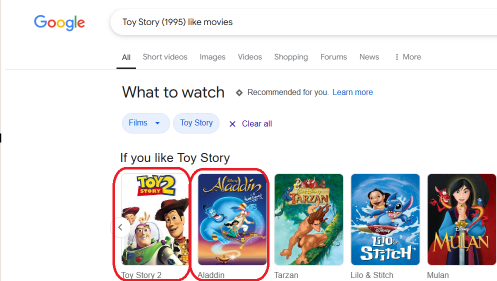

- Note, we are getting the same two movies as we got in case of Pearson corelation approach.
- No significant difference with KNN based approach

###Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.


In [ ]:
liar_movies = movies[movies['Title'].str.contains('Liar Liar', case=False, na=False)]
liar_movies

,Movie ID,Title,Genres
1455,1485,Liar Liar (1997),Comedy


In [ ]:
# Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.
movie_name = 'Liar Liar (1997)'
distances, indices = knn.kneighbors(tab[movie_name].values.reshape(1,-1),n_neighbors=4)
for i in range (0, len(distances.flatten())):
  if i == 0 :
    print("The movies close similar to",movie_name,"are \n")
  else:
    print(tab.columns[indices.flatten()[i]],"with a distance of",round(distances.flatten()[i],3))

The movies close similar to Liar Liar (1997) are 

Mrs. Doubtfire (1993) with a distance of 0.443
Ace Ventura: Pet Detective (1994) with a distance of 0.483
Dumb & Dumber (1994) with a distance of 0.487


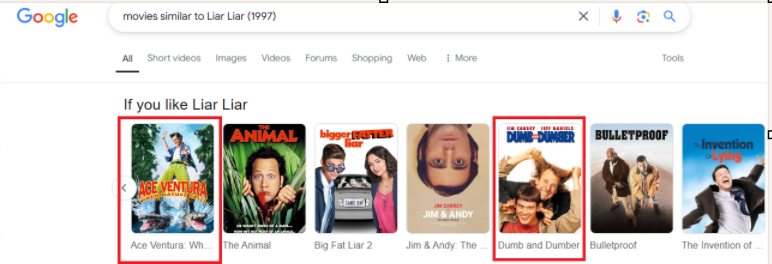

# Building a Recommender System based on Matrix Factorization

In [ ]:
users = df['User ID'].unique()
movies = df['Movie ID'].unique()

In [ ]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [ ]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [ ]:
df['UserID'] = df['User ID'].apply(lambda x : userid2idx[x])
df['MovieID'] = df['Movie ID'].apply(lambda x : movieid2idx[x])

In [ ]:
train = df[np.random.rand(len(df)) < 0.8]
valid = df[~(np.random.rand(len(df)) < 0.8)]
print(train.shape,valid.shape)

(800638, 13) (201016, 13)


In [ ]:
n_movies = len(df['Movie ID'].unique())
n_users = len(df['User ID'].unique())
n_latent_factors = 64 # Hyperparameter or hidden model factors

In [ ]:
# Creating embedding vector for user using embedding layer from Keras

import tensorflow as tf
user_input = tf.keras.Input(shape=(1,) ,name='user_input', dtype='int64')
user_embedding = tf.keras.layers.Embedding(n_users,n_latent_factors, name='user_embedding')(user_input)
user_vec = tf.keras.layers.Flatten(name='FlattenUsers')(user_embedding)

In [ ]:
# Creating embedding vector for movie using embedding layer from Keras

movie_input = tf.keras.Input(shape=(1,) ,name='movie_input', dtype='int64')
movie_embedding = tf.keras.layers.Embedding(n_users,n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = tf.keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

In [ ]:
from keras.layers import Dot

sim = Dot(name='Similarity-Dot-Product', axes=1)([user_vec, movie_vec])
model = keras.models.Model([user_input, movie_input], sim)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 64)     │    386,560 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 64)     │    386,560 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenUsers        │ (None, 64)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenMovies       │ (None, 64)        │          0 │ movie_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Similarity-Dot-Pro… │ (None, 1)         │          0 │ FlattenUsers[0][… │
│ (Dot)               │                   │            │ FlattenMovies[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 773,120 (2.95 MB)

 Trainable params: 773,120 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

- The metrics used here is Mean Squared Error (MSE)
- Our objective is to minimize this MSE on traing data set i.e over the values which user has rated

In [ ]:
# Model Training

model_hist = model.fit([train.UserID, train.MovieID], train.Rating, batch_size = 120, epochs = 20, validation_data = ([valid.UserID, valid.MovieID], valid.Rating), verbose = 1)

Epoch 1/20
6672/6672 ━━━━━━━━━━━━━━━━━━━━ 72s 11ms/step - loss: 14.0637 - val_loss: 13.2650
Epoch 2/20
6672/6672 ━━━━━━━━━━━━━━━━━━━━ 71s 11ms/step - loss: 11.4055 - val_loss: 4.7775
Epoch 3/20
6672/6672 ━━━━━━━━━━━━━━━━━━━━ 78s 12ms/step - loss: 3.6937 - val_loss: 1.9025
Epoch 4/20
6672/6672 ━━━━━━━━━━━━━━━━━━━━ 66s 9ms/step - loss: 1.6748 - val_loss: 1.2187
Epoch 5/20
6672/6672 ━━━━━━━━━━━━━━━━━━━━ 74s 11ms/step - loss: 1.1508 - val_loss: 0.9914
Epoch 6/20
6672/6672 ━━━━━━━━━━━━━━━━━━━━ 73s 11ms/step - loss: 0.9673 - val_loss: 0.9001
Epoch 7/20
6672/6672 ━━━━━━━━━━━━━━━━━━━━ 78s 12ms/step - loss: 0.8927 - val_loss: 0.8585
Epoch 8/20
6672/6672 ━━━━━━━━━━━━━━━━━━━━ 83s 12ms/step - loss: 0.8533 - val_loss: 0.8378
Epoch 9/20
6672/6672 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - loss: 0.8377 - val_loss: 0.8252
Epoch 10/20
6672/6672 ━━━━━━━━━━━━━━━━━━━━ 71s 11ms/step - loss: 0.8244 - val_loss: 0.8163
Epoch 11/20
6672/6672 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 0.8193 - val_loss: 0.8086
Epoch 1

In [ ]:
# Model Evaluation:

y_pred = model.predict([valid.UserID, valid.MovieID], verbose  =0)
y_pred_class  =np.argmax(y_pred, axis  =1)

In [ ]:
# RMSE

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(valid.Rating, y_pred)
print(f"RMSE : {rmse}")

In [ ]:
# MAPE

from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(valid.Rating, y_pred)
print(f"MAPE : {mape}")

MAPE : 0.2638208866119385


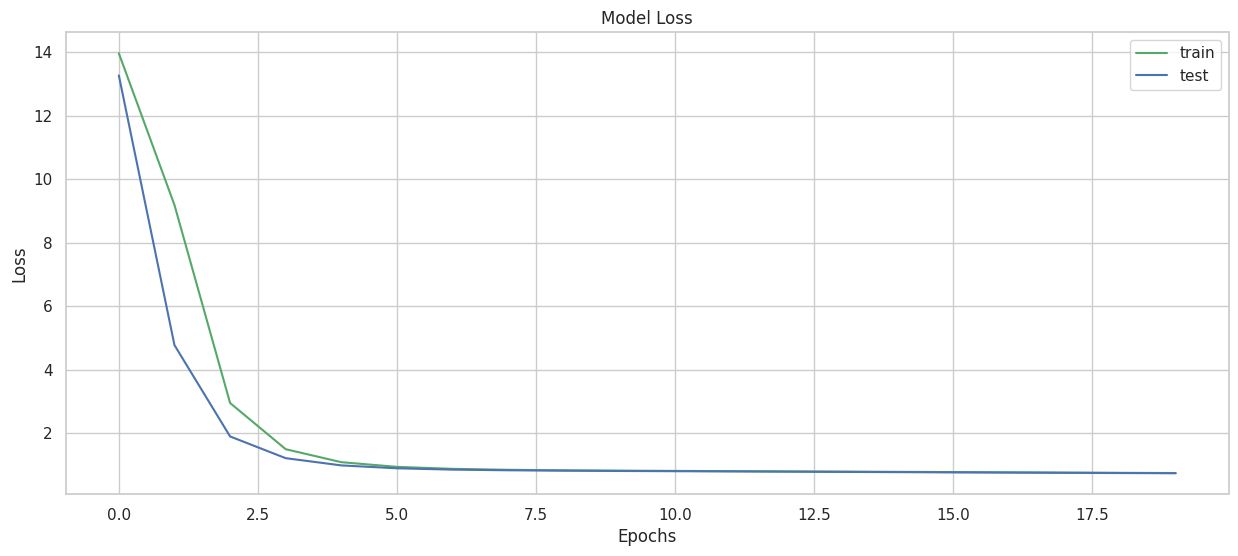

In [ ]:
# Plotting the model loss

# rcParams['figure.figsize'] = 10, 5
plt.plot(model_hist.history['loss'], 'g')
plt.plot(model_hist.history['val_loss'], 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.grid(True)
plt.show()

- As we can see, after 4 epochs, the loss is becoming almost constant.
- Train and test losses are coinsiding.
- The model is good.

In [ ]:
df

,Movie ID,Title,Genres,User ID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Release Year,UserID,MovieID
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,2001-01-06 23:37:48,F,Under 18,K-12 student,48067,1970-01-01 00:00:00.000001995,0,0
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,2000-12-31 04:30:08,F,50-55,homemaker,55117,1970-01-01 00:00:00.000001995,1,0
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,2000-12-31 03:31:36,M,25-34,programmer,11413,1970-01-01 00:00:00.000001995,2,0
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,2000-12-31 01:25:52,M,25-34,technician/engineer,61614,1970-01-01 00:00:00.000001995,3,0
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,2000-12-31 01:34:34,F,35-44,academic/educator,95370,1970-01-01 00:00:00.000001995,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,3952,"Contender, The (2000)",Drama|Thriller,5812,4,2001-06-09 07:34:59,F,25-34,executive/managerial,92120,1970-01-01 00:00:00.000002000,2279,3705
1000205,3952,"Contender, The (2000)",Drama|Thriller,5831,3,2001-04-02 14:52:05,M,25-34,academic/educator,92120,1970-01-01 00:00:00.000002000,2006,3705
1000206,3952,"Contender, The (2000)",Drama|Thriller,5837,4,2002-01-24 20:04:16,M,25-34,executive/managerial,60607,1970-01-01 00:00:00.000002000,2280,3705
1000207,3952,"Contender, The (2000)",Drama|Thriller,5927,1,2001-01-18 21:15:37,M,35-44,sales/marketing,10003,1970-01-01 00:00:00.000002000,2953,3705


### 1. Users of which age group have watched and rated the most number of movies?


In [ ]:
df.groupby('Age')['Rating'].count().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Count'})

,Age,Count
0,25-34,395556
1,35-44,199003
2,18-24,183536
3,45-49,83633
4,50-55,72490
5,56+,38780
6,Under 18,27211


###2. Users belonging to which profession have watched and rated the most movies?

In [ ]:
df.groupby('Occupation')['Rating'].count().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Count'})

,Occupation,Count
0,college/grad student,131032
1,other,130499
2,executive/managerial,105425
3,academic/educator,85351
4,technician/engineer,72816
5,writer,60397
6,programmer,57214
7,artist,50068
8,sales/marketing,49109
9,self-employed,46021


###3. Most of the users in our dataset who’ve rated the movies are Male.

In [ ]:
df.groupby('Gender')['Rating'].count().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Count'})

,Gender,Count
0,M,753769
1,F,246440


###4. Most of the movies present on our dataset were released in which decade?


In [ ]:
df.groupby('Release Year')['MovieID'].count().sort_values(ascending=False).to_frame().reset_index().head(20)

,Release Year,MovieID
0,1970-01-01 00:00:00.000001999,86833
1,1970-01-01 00:00:00.000001998,68222
2,1970-01-01 00:00:00.000001997,65402
3,1970-01-01 00:00:00.000001995,60754
4,1970-01-01 00:00:00.000001996,59382
5,1970-01-01 00:00:00.000001994,52963
6,1970-01-01 00:00:00.000001993,46317
7,1970-01-01 00:00:00.000002000,41000
8,1970-01-01 00:00:00.000001992,37866
9,1970-01-01 00:00:00.000001986,30865


###5. The movie with maximum no. of ratings


In [ ]:
df.groupby('Title')['Rating'].sum().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Ratings_Sum'}).head(5)

,Title,Ratings_Sum
0,American Beauty (1999),14800
1,Star Wars: Episode IV - A New Hope (1977),13321
2,Star Wars: Episode V - The Empire Strikes Back...,12836
3,Star Wars: Episode VI - Return of the Jedi (1983),11598
4,Saving Private Ryan (1998),11507


###6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.


In [ ]:
# 6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.
movie_name = 'Liar Liar (1997)'
distances, indices = knn.kneighbors(tab[movie_name].values.reshape(1,-1),n_neighbors=4)
for i in range (0, len(distances.flatten())):
  if i == 0 :
    print("The movies close similar to",movie_name,"are \n")
  else:
    print(tab.columns[indices.flatten()[i]],"with a distance of",round(distances.flatten()[i],3))


The movies close similar to Liar Liar (1997) are 

Mrs. Doubtfire (1993) with a distance of 0.443
Ace Ventura: Pet Detective (1994) with a distance of 0.483
Dumb & Dumber (1994) with a distance of 0.487


### **Questionnaire**:

1. Users of which age group have watched and rated the most number of movies?   
     - Ans -> 25-34 age group

2. Users belonging to which profession have watched and rated the most movies?
    - Ans -> college/grad student

3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)
    - Ans -> True (Male are most- 751,679)

4. Most of the movies present on our dataset were released in which decade?

    - Ans -> 90s

5. The movie with maximum no. of ratings is ___.
    - Ans ->American Beauty

6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.
    - Ans ->

        - Mrs. Doubtfire with a distance of 0.443
        - Ace Ventura: Pet Detective with a distance of 0.483
        - Dumb & Dumber with a distance of 0.487

7. On the basis of approach, Collaborative Filtering methods can be classified into memory-based and model-based.
    - Ans-> Memory based colab filtering has user-user and item-item whereas, model-based has Matrix Factorization

8. Pearson Correlation ranges between -1 to +1 whereas, Cosine Similarity belongs to the interval between 0 to 1

9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.
    - Ans ->
        - RMSE -87.17%
        - APE -> 27 %
10. Give the sparse ‘row’ matrix representation for the following dense matrix -
[[1 0] [3 7]]

    - Ans - CSR can be represented as

        - (0,0)1
        - (0,1)0
        - (1,0)3
        - (1,1)7
